In [16]:
#|default_exp datasets

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
from fastcore.all import *
from nbdev.showdoc import *
import torch

from autometric.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets
> What's on the tin! Pytorch utils to load our datasets, to make future use of them exceptionally easy.

**Notebook TODOs**

- [ ] The intrinsic coords are off by some rounding errors from the truth. Fix this. It involves the scaling, possible when ints are involved.

# Geometric Basis

Here we equip our datasets with *metrics*, allowing easy comparison with the ground truth. For consistency, we implement these manifolds as PyTorch immersions, so we can directly apply the goodness in `1 Geometer's Delight`.

In [17]:
#|export
import numpy as np
import scipy.optimize as opt
import sympy as sp

def manifold_density(f, variables):
    G = sp.Matrix.zeros(len(variables), len(variables))
    for i, x1 in enumerate(variables):
        for j, x2 in enumerate(variables):
            G[i,j] = (sp.diff(f, x1).T  * sp.diff(f, x2))[0]
    return sp.sqrt(G.det(method="lu"))

def max_value(expr, bounds):
    # Convert sympy expression to numpy function
    vars = list(expr.free_symbols)
    expr_neg = -1*expr
    neg_func = sp.lambdify([vars], expr_neg, 'numpy')

    # Minimize negative of function over range [-1, 1]
    bounds = [bounds for _ in vars] # TODO: fails when there are no vars
    res = opt.minimize(neg_func, np.zeros(len(vars)), bounds=bounds)
    
    # Return maximum value
    return -res.fun
def rejection_sample_from_surface(
        F, # a sympy matrix of size $N \times 1$ representing a surface
        n_points, # number of points to sample
        bounds=[-1,1], # bounds for each variable
        batch_size=1024, # number of points to test sampling at a time
        verbose=False,
        return_latent_vars=False,
):
    if verbose: print("Hey, just woke up")
    vars = sorted(F.free_symbols, key=lambda s: s.name)
    f = manifold_density(F, vars)
    g = 1/((bounds[1]-bounds[0])**len(vars)) # uniform density on [-1, 1] for each variable
    M = max_value(f/g, bounds=bounds) # M >= f/g for all x
    if verbose: print("Computed f, M, g")
    bouncer = (f / (M * g)) #.simplify()
    # print(bouncer)
    points = []
    latent_vars = []
    # convert f to numpy
    F_np = sp.lambdify([vars], F, 'numpy')
    bouncer_np = sp.lambdify([vars], bouncer, 'numpy')
    # add the origin as first point

    if verbose: print("Computed bouncer np")
    while len(points) < n_points:
        euc_coords = np.random.uniform(bounds[0], bounds[1], (batch_size,len(vars)))
        x = np.array(list(map(F_np,euc_coords)))
        if verbose: print("computed sample candidates")
        u = np.random.uniform(0, 1, batch_size)
        # print(u)
        # compute mask of points that pass the bouncer
        bouncer_results = np.array(list(map(bouncer_np,euc_coords)))
        if verbose: print("computed bouncer results")
        mask = u < bouncer_results
        points.extend(x[mask])
        latent_vars.extend(euc_coords[mask])
        if verbose:
            print(f"Points added {np.sum(mask)} for a total of {len(points)}")
        # if u < bouncer_np(euc_coords):
        #     points.extend(x)
    if len(points) > n_points:
        points = points[:n_points]
        latent_vars = latent_vars[:n_points]
    if return_latent_vars: 
        return np.squeeze(np.array(points)), np.squeeze(np.array(latent_vars))
    else: 
        return np.squeeze(np.array(points))

In [18]:
#|export
from autometric.metrics import PullbackMetric
from autometric.connections import LeviCivitaConnection
from autometric.manifolds import RiemannianManifold
import sympy as sym
import numpy as np
import sympytorch
import warnings
from torch.func import vmap

class ToyManifold:
    def __init__(
        self,
        F, # parameterization of manifold, as a sympy matrix of size $N \times 1$
        variable_bounds, 
        num_points = 2000, # num points to sample
    ):
        self.F = F
        params = sorted(F.free_symbols, key=lambda s: s.name)
        self.param_list = [str(f) for f in params]
        self.intrinsic_dimension = len(self.param_list)
        self.variable_bounds = variable_bounds
        self.X, self.intrinsic_coords = self.sample(num_points)
        self.X = torch.tensor(self.X)
        self.intrinsic_coords = torch.tensor(self.intrinsic_coords)
        # scale intrinsic coords back to 0,1
        self.intrinsic_coords = (self.intrinsic_coords - torch.min(self.intrinsic_coords))/(torch.max(self.intrinsic_coords)-torch.min(self.intrinsic_coords))
    
    def compute_metrics(self, compute_immersion = True):
        # compute metric information
        if compute_immersion:
            self.compute_immersion()
        self.metric = PullbackMetric(self.intrinsic_dimension, self.immersion)
        self.connection = LeviCivitaConnection(self.intrinsic_dimension, self.metric)
        self.manifold = RiemannianManifold(self.intrinsic_dimension, (1,1), metric = self.metric, connection = self.connection)
        # Compute basic manifold quantities
        try:
            self.ks = self.manifold.scalar_curvature(base_point = self.intrinsic_coords)
        except:
            warnings.warn("Something went awry during the scalar curvature computation.")

    def sample(
            self, num_points
    ):
        return rejection_sample_from_surface(
            F = self.F,
            n_points = num_points,
            bounds = self.variable_bounds,
            return_latent_vars=True,
        )
    
    def compute_immersion(self):
        # turns sympy extression into a pytorch function
        list_F = [item for sublist in self.F.tolist() for item in sublist]
        self.pytorch_function = sympytorch.SymPyModule(expressions = list_F)  
        # convert into a generic pytorch function that takes uniform samples in [0,1] and converts them to the right stuff.
        # the jacfwd functions from functorch go nuts with some negative inputs; hence the restriction.
        self.immersion = lambda x : self.pytorch_function(
            **{param: (x[i]*(self.variable_bounds[1] - self.variable_bounds[0]) + self.variable_bounds[0]) for i, param in enumerate(self.param_list)}
            )
        
    def plot(self, labels = None, title=""):
        if labels is None: labels = self.ks
        plot_3d(
            self.X.detach().numpy(),
            self.ks.detach().numpy(),
            title = title
        )

## Torus

In [19]:
#|export
class Torus(ToyManifold):
    def __init__(self,num_points = 2000, R=2.0, r=1.0):
        self.R, self.r = (R,r)
        theta = sym.Symbol('theta')
        phi = sym.Symbol('phi')
        F = sym.Matrix([(R + r*sym.cos(theta))*sym.cos(phi), (R + r*sym.cos(theta))*sym.sin(phi), r*sym.sin(theta)])
        super().__init__(F = F, variable_bounds = [0.0, 2*np.pi], num_points=num_points)
        self.compute_metrics()
    def scalar_curvature(self, X):
        theta = np.arcsin(X[:,2] / self.r)
        return 1/2*8*np.cos(theta)/(5 + np.cos(theta))

In [20]:
T = Torus()
x = torch.tensor([0.0,0.0])#torch.rand(2)
T.metric.metric_matrix(base_point = x)

tensor([[355.3058,   0.0000],
        [  0.0000,  39.4784]], dtype=torch.float64, grad_fn=<MmBackward0>)

In [21]:
# test that the scalar curvature computed with the metric matches the real scalar curvature
assert np.allclose(T.manifold.scalar_curvature(base_point = x).detach().numpy(),T.scalar_curvature(T.immersion(x).detach().numpy()[None,:])[0])

In [22]:
assert torch.allclose(
    vmap(T.immersion)(T.intrinsic_coords),
    T.X,
    atol = 1e-2
)

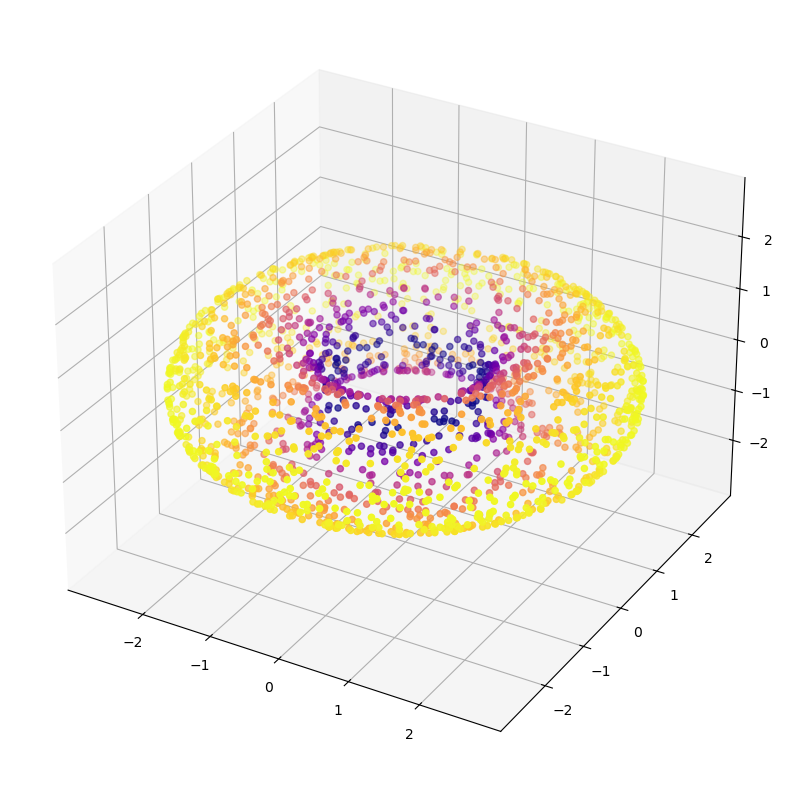

In [23]:
T.plot()

## Saddle

The library I'm using to convert SymPy expressions to PyTorch modules has some problems with squares, quite possibly among other things. Which is why, for this class, I'm overriding the immersion with a PyTorch version.

In [24]:
#|export
class Saddle(ToyManifold):
    def __init__(self, num_points = 2000, a=1, b = 1):
        # d = intrinsic_dim
        self.a, self.b = (a,b)
        x = sym.Symbol("x")
        y = sym.Symbol("y")
        F = sym.Matrix(
            [x,y,self.a*x**2 - self.b*y**2]
        )
        # vars = sp.symbols('x0:%d' % d)
        # F = sp.Matrix([*vars])
        # for i in range(d,d+1):
        #     F = F.row_insert(i, sp.Matrix([intensity*sum([(1)**j * vars[j]**2 for j in range(d)])]))
        #     print(F)
        super().__init__(F, variable_bounds = [-1, 1], num_points = num_points)
        self.compute_metrics(compute_immersion=False)
    def immersion(self, tensor_input):
        def pointwise_immersion(tensor_input):
            # scale input with bounds
            tensor_input = tensor_input*(self.variable_bounds[1] - self.variable_bounds[0]) + self.variable_bounds[0]
            x = tensor_input[0]
            y = tensor_input[1]
            return torch.vstack(
                [x, y, self.a*torch.square(x) - self.b*torch.square(y)]
            )
        if len(tensor_input.size()) == 1:
            return torch.squeeze(pointwise_immersion(tensor_input))
        else:
            return torch.squeeze(vmap(pointwise_immersion)(tensor_input))
    

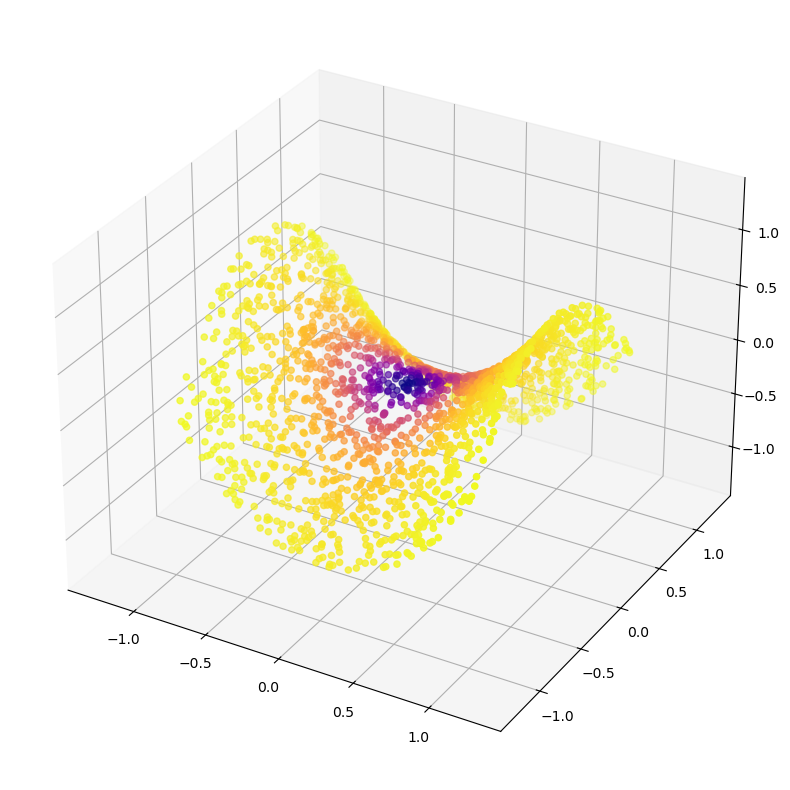

In [25]:
saddle_test = Saddle()
plot_3d(saddle_test.X, saddle_test.ks)

In [26]:
torch.allclose(
    vmap(saddle_test.immersion)(saddle_test.intrinsic_coords),
    saddle_test.X,
    atol = 1e-2
)

True

In [27]:
saddle_test.metric.metric_matrix(saddle_test.intrinsic_coords)

tensor([[[16.1402, -3.3016],
         [-3.3016,  4.8979]],

        [[ 4.2908,  0.0695],
         [ 0.0695,  4.0166]],

        [[ 5.6213, -2.6215],
         [-2.6215,  8.2386]],

        ...,

        [[10.6923,  9.8840],
         [ 9.8840, 18.5980]],

        [[ 9.6952, -3.6225],
         [-3.6225,  6.3042]],

        [[ 4.2306, -1.7220],
         [-1.7220, 16.8615]]], dtype=torch.float64)

## Ellipsoid

In [28]:
#|export
class Ellipsoid(ToyManifold):
    def __init__(self, num_points = 2000, a=3, b=2, c=1):
        theta = sym.Symbol("theta")
        phi = sym.Symbol("phi")
        F = sym.Matrix(
            [a*sym.cos(theta)*sym.sin(phi),b*sym.sin(theta)*sym.sin(phi),c*sym.cos(phi)]
        )
        super().__init__(F, [0.0,2*np.pi], num_points = num_points)
        self.compute_metrics()

In [29]:
elliptest = Ellipsoid()

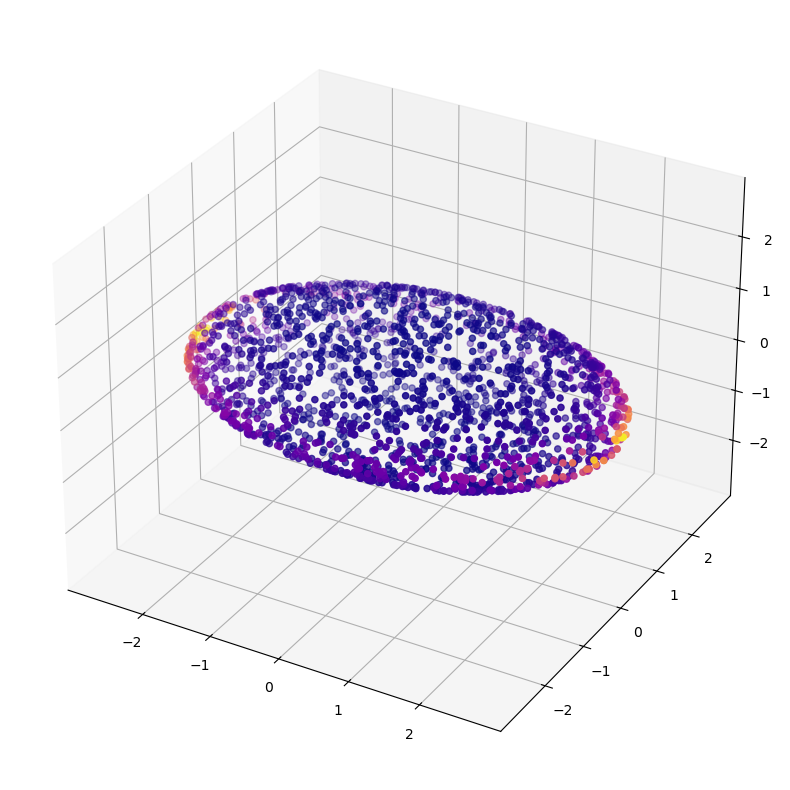

In [30]:
plot_3d(elliptest.X,elliptest.ks)

In [31]:
elliptest.intrinsic_coords[0]

tensor([0.9082, 0.0874], dtype=torch.float64)

In [32]:
elliptest.manifold.ricci_tensor(elliptest.intrinsic_coords)

tensor([[[  -3.1397,    2.0023],
         [   2.0023,  -11.1347]],

        [[-146.5093,   -2.8647],
         [  -2.8647,  -18.2083]],

        [[  -5.1381,   -1.8924],
         [  -1.8924,   -7.3683]],

        ...,

        [[-197.3030,   -8.7528],
         [  -8.7528,  -33.7269]],

        [[ -18.8086,   -1.9371],
         [  -1.9371,   -8.3962]],

        [[  -0.9137,    0.9769],
         [   0.9769,   -9.6234]]])

## Sphere

In [33]:
#|export
class Sphere(ToyManifold):
    def __init__(self, num_points = 2000, r = 1):
        self.r = r
        theta = sym.Symbol("theta")
        phi = sym.Symbol("phi")
        F = sym.Matrix(
            [r*sym.cos(theta)*sym.sin(phi),r*sym.sin(theta)*sym.sin(phi),r*sym.cos(phi)]
        )
        super().__init__(F, [0.0,2*np.pi], num_points = num_points)
        self.compute_metrics()
    def geodesic(self, 
                 a, # Coordinates in ambient space
                 b, 
                 tolerance = 0.02
                 ):
        """
        Returns geodesic in ambient space between points a and b.
        """
        cross = torch.cross(a, b, dim=-1)
        agreement_with_cross = torch.func.vmap(lambda x: torch.dot(cross, x))(self.X)
        great_circle_points = self.X[torch.abs(agreement_with_cross) < tolerance]
        # restrict to points on the right side
        agreement_with_sign = torch.func.vmap(lambda x: torch.dot(a + b, x))(great_circle_points)
        great_circle_points = great_circle_points[agreement_with_sign > 0]
        angle = torch.linalg.norm(torch.cross(a, b, dim=-1))/self.r**2
        length = self.r * angle
        return length, great_circle_points

In [34]:
S = Sphere()
length, points = S.geodesic(S.X[0], S.X[1], tolerance=0.02)

## Hemisphere

In [35]:
#|export
class Hemisphere(Sphere):
    def __init__(self, num_points = 2000, r = 1):
        super().__init__(num_points, r, threshold=0)
        self.X = self.X[self.X[:,2] > threshold]

In [36]:
S = Hemisphere()
length, points = S.geodesic(S.X[0], S.X[1], tolerance=0.02)

# PyTorch Machinery

In [37]:
#|export
import torch

class PointcloudDataset(torch.utils.data.Dataset):
    def __init__(self, pointcloud):
        self.pointcloud = torch.tensor(pointcloud, dtype=torch.float32)
        
    def __len__(self):
        return len(self.pointcloud)
    
    def __getitem__(self, idx):
        return self.pointcloud[idx]

class PointcloudWithDistancesDataset(torch.utils.data.Dataset):
    def __init__(self, pointcloud, distances, batch_size = 64):
        self.pointcloud = torch.tensor(pointcloud, dtype=torch.float32)
        self.distances = torch.tensor(distances, dtype=torch.float32)
        self.batch_size = batch_size

    def __len__(self):
        return len(self.pointcloud)
    
    def __getitem__(self, idx):
        batch_idxs = torch.randperm(len(self.pointcloud))[:self.batch_size]
        batch = {}
        batch['x'] = self.pointcloud[batch_idxs]
        batch['d'] = self.distances[batch_idxs][:,batch_idxs]
        return batch

In [38]:
#|export
def dataloader_from_pointcloud_with_distances(pointcloud, distances, batch_size = 64):
    dataset = PointcloudWithDistancesDataset(pointcloud, distances, batch_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=None, shuffle=True)
    return dataloader

In [39]:
#|export
def train_and_testloader_from_pointcloud_with_distances(
    pointcloud, distances, batch_size = 64, train_test_split = 0.8
):
    X = pointcloud
    D = distances
    split_idx = int(len(X)*train_test_split)
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    D_train = D[:split_idx,:split_idx]
    D_test = D[split_idx:,split_idx:]
    trainloader = dataloader_from_pointcloud_with_distances(X_train, D_train, batch_size)
    testloader = dataloader_from_pointcloud_with_distances(X_test, D_test, batch_size)
    return trainloader, testloader

# Compiling the datasets
Though defined in other notebooks, we compile the datasets here for ease of use.

In [40]:
#|export
import numpy as np
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

def plot_3d_vector_field(X, *vector_fields, names=None, arrow_length=0.5, upload_to_information_superhighway = False, username = "", api_key = "", filename = ""):
    """
    Create a 3D quiver plot with multiple vector fields.

    Args:
        X (list of tuples or arrays): Collection of points in 3D space.
        *vector_fields: Variable number of vector fields (lists of tuples or arrays).
        arrow_length (float): Scaling factor for arrow lengths.

    Returns:
        None
    """
    if names is None:
        names = [f"Vector Field {i}" for i in range(len(vector_fields))]
    
    fig = go.Figure()

    # Convert to NumPy array for vectorized operations
    X = np.array(X)

    # Generate a list of colors
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'brown', 'pink', 'grey', 'cyan']
    if len(vector_fields) > len(colors):
        # Generate more colors if needed
        additional_colors = np.random.choice(colors, size=(len(vector_fields) - len(colors)))
        colors.extend(additional_colors)

    # Function to add arrows (vectors)
    def add_arrows(X, V, color, name):
        V = np.array(V) * arrow_length
        end_points = X + V
    
        # Arrows (cones)
        fig.add_trace(go.Cone(
            x=end_points[:, 0],
            y=end_points[:, 1],
            z=end_points[:, 2],
            u=V[:, 0],
            v=V[:, 1],
            w=V[:, 2],
            sizemode='absolute',
            sizeref=0.1,
            showscale=False,
            colorscale=[[0, color], [1, color]],
            cmin=0,
            cmax=1,
            name=name,
            legendgroup=name,
            showlegend=True  # Set to True to show in legend
        ))
    
        # Lines (arrow shafts)
        for start, end in zip(X, end_points):
            fig.add_trace(go.Scatter3d(
                x=[start[0], end[0]],
                y=[start[1], end[1]],
                z=[start[2], end[2]],
                mode='lines',
                line=dict(width=3, color=color),
                showlegend=False  # Set to False to avoid duplicate legend entries
            ))


    # Markers for points
    fig.add_trace(go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode='markers',
        marker=dict(size=5, color='black'),
        name='Points',
        showlegend=False
    ))

    # Add arrows for each vector field
    for i, vector_field in enumerate(vector_fields):
        add_arrows(X, vector_field, colors[i % len(colors)], names[i])

    # Set axis labels
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ), title=filename)

    # Show the plot
    fig.show()
    if upload_to_information_superhighway:
        url = py.plot(fig, filename = filename, auto_open=False)
        print("Your plot is now live at ",url)


In [41]:
#|export
def sphere_with_normals(
    n_points
):
    X, ks = sphere(n_points)
    N = X
    return X, N

# Exporting Datasets

In [42]:
#|export
import os
from fastcore.script import *

@call_parse
def export_datasets(
    foldername:str,
    num_points:int = 2000, # Number of samples from each dataset 
):
    """
    Saves all of the datasets above into npz files.
    """
    dsets = [
        Sphere, Torus, Hemisphere, Saddle, Ellipsoid
    ]
    for dset in dsets:
        D = dset(num_points = num_points)
        np.savez(
            os.path.join(foldername, f'{dset.__name__}.npz'), 
            data = D.X.detach().numpy(), 
            ks = D.ks.detach().numpy(),
            colors = D.ks.detach().numpy(),
        )